In [3]:
import uproot
import awkward as ak
import numpy as np
#input_tree_md = uproot.open({"/work/guenther/reco_tuner/data/param_data_MD_selected_8520.root": "Selected"})
#input_tree_mu = uproot.open({"/work/guenther/reco_tuner/data/param_data_MU_selected_8520.root": "Selected"})
input_tree = uproot.open({"/work/guenther/reco_tuner/data/param_data_selected.root": "Selected"})
# this is an event list of dictionaries containing awkward arrays
#array_md = input_tree_md.arrays()
#array_mu = input_tree_mu.arrays()
#array = ak.concatenate([array_md, array_mu])
array = input_tree.arrays()
array["dSlope_fringe"] = array["tx_ref"] - array["tx"]
array["dSlope_fringe_abs"] = abs(array["dSlope_fringe"])
array["z_mag_x_fringe"] = (array["x"] - array["x_ref"] - array["tx"] * array["z"] + array["tx_ref"] * array["z_ref"] ) / array["dSlope_fringe"]
array["yStraightRef"] = array["y"] + array["ty"] * ( array["z_ref"] - array["z"])
array["AY_straight_diff"] = array["AY_ex"] - array["yStraightRef"]
array["y_ref_straight_diff"] = array["y_ref"] - array["yStraightRef"]
array["y_straight_diff_l1"] = array["y_l1"] - array["y"] - array["ty"] * ( array["z_l1"] - array["z"])
array["y_straight_diff_l2"] = array["y_l2"] - array["y"] - array["ty"] * ( array["z_l2"] - array["z"])
array["y_straight_diff_l5"] = array["y_l5"] - array["y"] - array["ty"] * ( array["z_l5"] - array["z"])
array["y_straight_diff_l6"] = array["y_l6"] - array["y"] - array["ty"] * ( array["z_l6"] - array["z"])
array["y_straight_diff_l9"] = array["y_l9"] - array["y"] - array["ty"] * ( array["z_l9"] - array["z"])
array["y_straight_diff_l10"] = array["y_l10"] - array["y"] - array["ty"] * ( array["z_l10"] - array["z"])
array["BY_straight_diff"] = array["BY_ex"] - array["ty"]
array["ty_ref_straight_diff"] = array["ty_ref"] - array["ty"]
def format_array(name, coef):
    coef = [str(c)+"f" for c in coef if c != 0.0]
    code = f"constexpr std::array {name}"
    code += "{" + ", ".join(list(coef)) +"};"
    return code

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

features = [
    "ty", 
    "tx",
    "dSlope_fringe",
    "dSlope_fringe_abs"
]
target_feat = "y_ref_straight_diff"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=6, include_bias=False)
X_train_model = poly.fit_transform( X_train )
X_test_model = poly.fit_transform( X_test )
poly_features = poly.get_feature_names_out(input_features=features)
#print(poly_features)
keep = [
    "ty dSlope_fringe_abs", 
    "ty tx^2 dSlope_fringe_abs", 
    "ty^3 dSlope_fringe_abs", 
    "ty^3 tx^2 dSlope_fringe_abs",
    "dSlope_fringe",
    "ty tx dSlope_fringe",
    "ty tx^3 dSlope_fringe",
    "ty^3 tx dSlope_fringe",
]
remove = [i for i, f in enumerate(poly_features) if f not in keep]
X_train_model = np.delete( X_train_model, remove, axis=1)
X_test_model = np.delete( X_test_model, remove, axis=1)
poly_features = np.delete(poly_features, remove )
print(poly_features)

lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit( X_train_model, y_train)
y_pred_test = lin_reg.predict( X_test_model )
print("intercept=", lin_reg.intercept_)
print("coef=", dict(zip(poly_features, lin_reg.coef_)))
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print("straight RMSE =", mean_squared_error(array["y_ref"], array["y"] + array["ty"] * ( array["z_ref"] - array["z"] ), squared=False))
print(format_array("y_ref_straight_diff", lin_reg.coef_))

['dSlope_fringe' 'ty dSlope_fringe_abs' 'ty tx dSlope_fringe'
 'ty^3 dSlope_fringe_abs' 'ty tx^2 dSlope_fringe_abs'
 'ty^3 tx dSlope_fringe' 'ty tx^3 dSlope_fringe'
 'ty^3 tx^2 dSlope_fringe_abs']
intercept= 0.0
coef= {'dSlope_fringe': 2.54927052921483, 'ty dSlope_fringe_abs': 65.18649309504633, 'ty tx dSlope_fringe': 4174.444641065072, 'ty^3 dSlope_fringe_abs': -10543.061353132687, 'ty tx^2 dSlope_fringe_abs': 812.6329282763543, 'ty^3 tx dSlope_fringe': 52906.81696296328, 'ty tx^3 dSlope_fringe': 37770.21841979088, 'ty^3 tx^2 dSlope_fringe_abs': 273401.3548544383}
r2 score= 0.9424448007543189
RMSE = 8.058017702810291
straight RMSE = 33.93970007402008
constexpr std::array y_ref_straight_diff{2.54927052921483f, 65.18649309504633f, 4174.444641065072f, -10543.061353132687f, 812.6329282763543f, 52906.81696296328f, 37770.21841979088f, 273401.3548544383f};


In [5]:
features = [
    "ty", 
    "tx",
    "dSlope_fringe",
    "dSlope_fringe_abs"
]
target_feat = "y_straight_diff_l1"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=6, include_bias=False)
X_train_model = poly.fit_transform( X_train )
X_test_model = poly.fit_transform( X_test )
poly_features = poly.get_feature_names_out(input_features=features)
#print(poly_features)
keep = [
    "ty dSlope_fringe_abs", 
    "ty tx^2 dSlope_fringe_abs", 
    "ty^3 dSlope_fringe_abs", 
    "ty^3 tx^2 dSlope_fringe_abs",
    "dSlope_fringe",
    "ty tx dSlope_fringe",
    "ty tx^3 dSlope_fringe",
    "ty^3 tx dSlope_fringe",
]
remove = [i for i, f in enumerate(poly_features) if f not in keep]
X_train_model = np.delete( X_train_model, remove, axis=1)
X_test_model = np.delete( X_test_model, remove, axis=1)
poly_features = np.delete(poly_features, remove )
print(poly_features)

lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit( X_train_model, y_train)
y_pred_test = lin_reg.predict( X_test_model )
print("intercept=", lin_reg.intercept_)
print("coef=", dict(zip(poly_features, lin_reg.coef_)))
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print("straight RMSE =", mean_squared_error(array["y_l1"], array["y"] + array["ty"] * ( array["z_l1"] - array["z"] ), squared=False))
print(format_array("y_straight_diff_l1", lin_reg.coef_))

['dSlope_fringe' 'ty dSlope_fringe_abs' 'ty tx dSlope_fringe'
 'ty^3 dSlope_fringe_abs' 'ty tx^2 dSlope_fringe_abs'
 'ty^3 tx dSlope_fringe' 'ty tx^3 dSlope_fringe'
 'ty^3 tx^2 dSlope_fringe_abs']
intercept= 0.0
coef= {'dSlope_fringe': 1.926395569816899, 'ty dSlope_fringe_abs': 155.7194258002827, 'ty tx dSlope_fringe': 3711.2012601369147, 'ty^3 dSlope_fringe_abs': -6986.454915191362, 'ty tx^2 dSlope_fringe_abs': -102.59383584048052, 'ty^3 tx dSlope_fringe': 42360.930984198254, 'ty tx^3 dSlope_fringe': 29857.060893721067, 'ty^3 tx^2 dSlope_fringe_abs': 209095.7911514973}
r2 score= 0.9391433516368133
RMSE = 6.578135946782935
straight RMSE = 26.874058521627408
constexpr std::array y_straight_diff_l1{1.926395569816899f, 155.7194258002827f, 3711.2012601369147f, -6986.454915191362f, -102.59383584048052f, 42360.930984198254f, 29857.060893721067f, 209095.7911514973f};


In [6]:
features = [
    "ty", 
    "tx",
    "dSlope_fringe",
    "dSlope_fringe_abs"
]
target_feat = "y_straight_diff_l2"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=6, include_bias=False)
X_train_model = poly.fit_transform( X_train )
X_test_model = poly.fit_transform( X_test )
poly_features = poly.get_feature_names_out(input_features=features)
#print(poly_features)
keep = [
    "ty dSlope_fringe_abs", 
    "ty tx^2 dSlope_fringe_abs", 
    "ty^3 dSlope_fringe_abs", 
    "ty^3 tx^2 dSlope_fringe_abs",
    "dSlope_fringe",
    "ty tx dSlope_fringe",
    "ty tx^3 dSlope_fringe",
    "ty^3 tx dSlope_fringe",
]
remove = [i for i, f in enumerate(poly_features) if f not in keep]
X_train_model = np.delete( X_train_model, remove, axis=1)
X_test_model = np.delete( X_test_model, remove, axis=1)
poly_features = np.delete(poly_features, remove )
print(poly_features)

lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit( X_train_model, y_train)
y_pred_test = lin_reg.predict( X_test_model )
print("intercept=", lin_reg.intercept_)
print("coef=", dict(zip(poly_features, lin_reg.coef_)))
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print("straight RMSE =", mean_squared_error(array["y_l2"], array["y"] + array["ty"] * ( array["z_l2"] - array["z"] ), squared=False))
print(format_array("y_straight_diff_l2", lin_reg.coef_))

['dSlope_fringe' 'ty dSlope_fringe_abs' 'ty tx dSlope_fringe'
 'ty^3 dSlope_fringe_abs' 'ty tx^2 dSlope_fringe_abs'
 'ty^3 tx dSlope_fringe' 'ty tx^3 dSlope_fringe'
 'ty^3 tx^2 dSlope_fringe_abs']
intercept= 0.0
coef= {'dSlope_fringe': 1.992023095115273, 'ty dSlope_fringe_abs': 147.53158307285184, 'ty tx dSlope_fringe': 3758.3638141105685, 'ty^3 dSlope_fringe_abs': -7387.838564546752, 'ty tx^2 dSlope_fringe_abs': -20.05844697530397, 'ty^3 tx dSlope_fringe': 43544.55794543203, 'ty tx^3 dSlope_fringe': 30729.099594836473, 'ty^3 tx^2 dSlope_fringe_abs': 216301.09830837924}
r2 score= 0.939662275160689
RMSE = 6.726003215973192
straight RMSE = 27.60567927172973
constexpr std::array y_straight_diff_l2{1.992023095115273f, 147.53158307285184f, 3758.3638141105685f, -7387.838564546752f, -20.05844697530397f, 43544.55794543203f, 30729.099594836473f, 216301.09830837924f};


In [7]:
features = [
    "ty", 
    "tx",
    "dSlope_fringe",
    "dSlope_fringe_abs"
]
target_feat = "y_straight_diff_l5"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=6, include_bias=False)
X_train_model = poly.fit_transform( X_train )
X_test_model = poly.fit_transform( X_test )
poly_features = poly.get_feature_names_out(input_features=features)
#print(poly_features)
keep = [
    "ty dSlope_fringe_abs", 
    "ty tx^2 dSlope_fringe_abs", 
    "ty^3 dSlope_fringe_abs", 
    "ty^3 tx^2 dSlope_fringe_abs",
    "dSlope_fringe",
    "ty tx dSlope_fringe",
    "ty tx^3 dSlope_fringe",
    "ty^3 tx dSlope_fringe",
]
remove = [i for i, f in enumerate(poly_features) if f not in keep]
X_train_model = np.delete( X_train_model, remove, axis=1)
X_test_model = np.delete( X_test_model, remove, axis=1)
poly_features = np.delete(poly_features, remove )
print(poly_features)

lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit( X_train_model, y_train)
y_pred_test = lin_reg.predict( X_test_model )
print("intercept=", lin_reg.intercept_)
print("coef=", dict(zip(poly_features, lin_reg.coef_)))
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print("straight RMSE =", mean_squared_error(array["y_l5"], array["y"] + array["ty"] * ( array["z_l5"] - array["z"] ), squared=False))
print(format_array("y_straight_diff_l5", lin_reg.coef_))

['dSlope_fringe' 'ty dSlope_fringe_abs' 'ty tx dSlope_fringe'
 'ty^3 dSlope_fringe_abs' 'ty tx^2 dSlope_fringe_abs'
 'ty^3 tx dSlope_fringe' 'ty tx^3 dSlope_fringe'
 'ty^3 tx^2 dSlope_fringe_abs']
intercept= 0.0
coef= {'dSlope_fringe': 2.6109097507814067, 'ty dSlope_fringe_abs': 55.23845097538265, 'ty tx dSlope_fringe': 4222.757834030979, 'ty^3 dSlope_fringe_abs': -10869.286047558253, 'ty tx^2 dSlope_fringe_abs': 913.7370293450639, 'ty^3 tx dSlope_fringe': 53875.65687892285, 'ty tx^3 dSlope_fringe': 38512.63398443023, 'ty^3 tx^2 dSlope_fringe_abs': 279346.89317804825}
r2 score= 0.9426062193562865
RMSE = 8.213743029204338
straight RMSE = 34.65071255550859
constexpr std::array y_straight_diff_l5{2.6109097507814067f, 55.23845097538265f, 4222.757834030979f, -10869.286047558253f, 913.7370293450639f, 53875.65687892285f, 38512.63398443023f, 279346.89317804825f};


In [8]:
features = [
    "ty", 
    "tx",
    "dSlope_fringe",
    "dSlope_fringe_abs"
]
target_feat = "y_straight_diff_l6"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=6, include_bias=False)
X_train_model = poly.fit_transform( X_train )
X_test_model = poly.fit_transform( X_test )
poly_features = poly.get_feature_names_out(input_features=features)
#print(poly_features)
keep = [
    "ty dSlope_fringe_abs", 
    "ty tx^2 dSlope_fringe_abs", 
    "ty^3 dSlope_fringe_abs", 
    "ty^3 tx^2 dSlope_fringe_abs",
    "dSlope_fringe",
    "ty tx dSlope_fringe",
    "ty tx^3 dSlope_fringe",
    "ty^3 tx dSlope_fringe",
]
remove = [i for i, f in enumerate(poly_features) if f not in keep]
X_train_model = np.delete( X_train_model, remove, axis=1)
X_test_model = np.delete( X_test_model, remove, axis=1)
poly_features = np.delete(poly_features, remove )
print(poly_features)

lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit( X_train_model, y_train)
y_pred_test = lin_reg.predict( X_test_model )
print("intercept=", lin_reg.intercept_)
print("coef=", dict(zip(poly_features, lin_reg.coef_)))
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print("straight RMSE =", mean_squared_error(array["y_l6"], array["y"] + array["ty"] * ( array["z_l6"] - array["z"] ), squared=False))
print(format_array("y_straight_diff_l6", lin_reg.coef_))

['dSlope_fringe' 'ty dSlope_fringe_abs' 'ty tx dSlope_fringe'
 'ty^3 dSlope_fringe_abs' 'ty tx^2 dSlope_fringe_abs'
 'ty^3 tx dSlope_fringe' 'ty tx^3 dSlope_fringe'
 'ty^3 tx^2 dSlope_fringe_abs']
intercept= 0.0
coef= {'dSlope_fringe': 2.6869036549491536, 'ty dSlope_fringe_abs': 42.86164139009395, 'ty tx dSlope_fringe': 4282.473673540287, 'ty^3 dSlope_fringe_abs': -11261.305925638624, 'ty tx^2 dSlope_fringe_abs': 1038.8682634234196, 'ty^3 tx dSlope_fringe': 55053.993311126746, 'ty tx^3 dSlope_fringe': 39412.35231667733, 'ty^3 tx^2 dSlope_fringe_abs': 286552.2319656697}
r2 score= 0.9427768256184441
RMSE = 8.406185401645494
straight RMSE = 35.523013512241214
constexpr std::array y_straight_diff_l6{2.6869036549491536f, 42.86164139009395f, 4282.473673540287f, -11261.305925638624f, 1038.8682634234196f, 55053.993311126746f, 39412.35231667733f, 286552.2319656697f};


In [9]:
features = [
    "ty", 
    "tx",
    "dSlope_fringe",
    "dSlope_fringe_abs"
]
target_feat = "y_straight_diff_l9"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=6, include_bias=False)
X_train_model = poly.fit_transform( X_train )
X_test_model = poly.fit_transform( X_test )
poly_features = poly.get_feature_names_out(input_features=features)
#print(poly_features)
keep = [
    "ty dSlope_fringe_abs", 
    "ty tx^2 dSlope_fringe_abs", 
    "ty^3 dSlope_fringe_abs", 
    "ty^3 tx^2 dSlope_fringe_abs",
    "dSlope_fringe",
    "ty tx dSlope_fringe",
    "ty tx^3 dSlope_fringe",
    "ty^3 tx dSlope_fringe",
]
remove = [i for i, f in enumerate(poly_features) if f not in keep]
X_train_model = np.delete( X_train_model, remove, axis=1)
X_test_model = np.delete( X_test_model, remove, axis=1)
poly_features = np.delete(poly_features, remove )
print(poly_features)

lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit( X_train_model, y_train)
y_pred_test = lin_reg.predict( X_test_model )
print("intercept=", lin_reg.intercept_)
print("coef=", dict(zip(poly_features, lin_reg.coef_)))
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print("straight RMSE =", mean_squared_error(array["y_l9"], array["y"] + array["ty"] * ( array["z_l9"] - array["z"] ), squared=False))
print(format_array("y_straight_diff_l9", lin_reg.coef_))

['dSlope_fringe' 'ty dSlope_fringe_abs' 'ty tx dSlope_fringe'
 'ty^3 dSlope_fringe_abs' 'ty tx^2 dSlope_fringe_abs'
 'ty^3 tx dSlope_fringe' 'ty tx^3 dSlope_fringe'
 'ty^3 tx^2 dSlope_fringe_abs']
intercept= 0.0
coef= {'dSlope_fringe': 3.3840782993219154, 'ty dSlope_fringe_abs': -73.66219618861146, 'ty tx dSlope_fringe': 4855.8672756860515, 'ty^3 dSlope_fringe_abs': -14629.483020343234, 'ty tx^2 dSlope_fringe_abs': 2208.9899749295746, 'ty^3 tx dSlope_fringe': 65168.34060362849, 'ty tx^3 dSlope_fringe': 47225.377082479885, 'ty^3 tx^2 dSlope_fringe_abs': 349003.88327916135}
r2 score= 0.943344616193092
RMSE = 10.238398557856689
straight RMSE = 43.54352590748684
constexpr std::array y_straight_diff_l9{3.3840782993219154f, -73.66219618861146f, 4855.8672756860515f, -14629.483020343234f, 2208.9899749295746f, 65168.34060362849f, 47225.377082479885f, 349003.88327916135f};


In [10]:
features = [
    "ty", 
    "tx",
    "dSlope_fringe",
    "dSlope_fringe_abs"
]
target_feat = "y_straight_diff_l10"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=6, include_bias=False)
X_train_model = poly.fit_transform( X_train )
X_test_model = poly.fit_transform( X_test )
poly_features = poly.get_feature_names_out(input_features=features)
#print(poly_features)
keep = [
    "ty dSlope_fringe_abs", 
    "ty tx^2 dSlope_fringe_abs", 
    "ty^3 dSlope_fringe_abs", 
    "ty^3 tx^2 dSlope_fringe_abs",
    "dSlope_fringe",
    "ty tx dSlope_fringe",
    "ty tx^3 dSlope_fringe",
    "ty^3 tx dSlope_fringe",
]
remove = [i for i, f in enumerate(poly_features) if f not in keep]
X_train_model = np.delete( X_train_model, remove, axis=1)
X_test_model = np.delete( X_test_model, remove, axis=1)
poly_features = np.delete(poly_features, remove )
print(poly_features)

lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit( X_train_model, y_train)
y_pred_test = lin_reg.predict( X_test_model )
print("intercept=", lin_reg.intercept_)
print("coef=", dict(zip(poly_features, lin_reg.coef_)))
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print("straight RMSE =", mean_squared_error(array["y_l10"], array["y"] + array["ty"] * ( array["z_l10"] - array["z"] ), squared=False))
print(format_array("y_straight_diff_l10", lin_reg.coef_))

['dSlope_fringe' 'ty dSlope_fringe_abs' 'ty tx dSlope_fringe'
 'ty^3 dSlope_fringe_abs' 'ty tx^2 dSlope_fringe_abs'
 'ty^3 tx dSlope_fringe' 'ty tx^3 dSlope_fringe'
 'ty^3 tx^2 dSlope_fringe_abs']
intercept= 0.0
coef= {'dSlope_fringe': 3.466479515860849, 'ty dSlope_fringe_abs': -87.54166562301657, 'ty tx dSlope_fringe': 4926.350778945553, 'ty^3 dSlope_fringe_abs': -15008.616026945787, 'ty tx^2 dSlope_fringe_abs': 2347.3262833969093, 'ty^3 tx dSlope_fringe': 66293.67978997533, 'ty tx^3 dSlope_fringe': 48106.815974854835, 'ty^3 tx^2 dSlope_fringe_abs': 356053.9012962991}
r2 score= 0.9433372187768841
RMSE = 10.46108881485266
straight RMSE = 44.49300835626165
constexpr std::array y_straight_diff_l10{3.466479515860849f, -87.54166562301657f, 4926.350778945553f, -15008.616026945787f, 2347.3262833969093f, 66293.67978997533f, 48106.815974854835f, 356053.9012962991f};


In [41]:
features = [
    "ty", 
    "tx",
    "dSlope_fringe",
    "dSlope_fringe_abs"
]
target_feat = "ty_ref_straight_diff"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=6, include_bias=False)
X_train_model = poly.fit_transform( X_train )
X_test_model = poly.fit_transform( X_test )
poly_features = poly.get_feature_names_out(input_features=features)
#print(poly_features)
keep = [
    "ty dSlope_fringe^2",
    #"ty dSlope_fringe_abs", 
    "ty tx^2 dSlope_fringe_abs", 
    "ty^3 dSlope_fringe_abs", 
    "ty^3 tx^2 dSlope_fringe_abs",
    #"dSlope_fringe",
    "ty tx dSlope_fringe",
    "ty tx^3 dSlope_fringe",
    #"ty^3 tx dSlope_fringe",
]
remove = [i for i, f in enumerate(poly_features) if f not in keep]
#remove = [i for i, f in enumerate(poly_features) if ("dSlope_fringe" not in f) or ("dSlope_fringe^" in f) or ("dSlope_fringe_abs^" in f) or ("dSlope_fringe dSlope_fringe_abs" in f)]
X_train_model = np.delete( X_train_model, remove, axis=1)
X_test_model = np.delete( X_test_model, remove, axis=1)
poly_features = np.delete(poly_features, remove )
#print(poly_features)

lin_reg = LinearRegression(fit_intercept=False)
#lin_reg = Lasso(fit_intercept=False, alpha=0.0000000001)
lin_reg.fit( X_train_model, y_train)
y_pred_test = lin_reg.predict( X_test_model )
print("intercept=", lin_reg.intercept_)
print("coef=", dict(zip(poly_features, lin_reg.coef_)))
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
print("straight RMSE =", mean_squared_error(array["ty_ref"], array["ty"], squared=False))
print(format_array("ty_ref_straight_diff", lin_reg.coef_))

intercept= 0.0
coef= {'ty tx dSlope_fringe': 0.9394190987843558, 'ty dSlope_fringe^2': -0.46480920487603206, 'ty^3 dSlope_fringe_abs': -4.137993544858158, 'ty tx^2 dSlope_fringe_abs': 2.980803780828937, 'ty tx^3 dSlope_fringe': 12.402177409386482, 'ty^3 tx^2 dSlope_fringe_abs': 38.238656269022954}
r2 score= 0.9649625489427109
RMSE = 0.0025237463237113896
straight RMSE = 0.013705994187091751
constexpr std::array ty_ref_straight_diff{0.9394190987843558f, -0.46480920487603206f, -4.137993544858158f, 2.980803780828937f, 12.402177409386482f, 38.238656269022954f};


<AxesSubplot: >

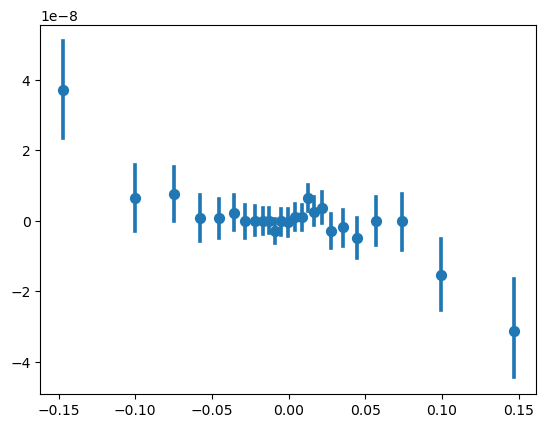

In [12]:
import seaborn as sns
import numpy as np
bins = 25#np.linspace( -1.5, 1.5, 50 )
sns.regplot(x=ak.to_numpy(array["tx"]), y=ak.to_numpy(array["CY_ex"]), x_bins=bins, fit_reg=None, x_estimator=np.mean)

In [26]:
features = [
    "ty", 
    "tx",
    "dSlope_fringe",
    "dSlope_fringe_abs"
]
target_feat = "CY_ex"

data = np.column_stack([ak.to_numpy(array[feat]) for feat in features])
target = ak.to_numpy(array[target_feat])
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

poly = PolynomialFeatures(degree=4, include_bias=False)
X_train_model = poly.fit_transform( X_train )
X_test_model = poly.fit_transform( X_test )
poly_features = poly.get_feature_names_out(input_features=features)
#print(poly_features)
keep = [
    "ty dSlope_fringe^2",
    "ty dSlope_fringe_abs", 
    "ty tx^2 dSlope_fringe_abs", 
    "ty^3 dSlope_fringe_abs", 
    #"ty^3 tx^2 dSlope_fringe_abs",
    #"dSlope_fringe",
    "ty tx dSlope_fringe",
    #"ty tx^3 dSlope_fringe",
    #"ty^3 tx dSlope_fringe",
]
remove = [i for i, f in enumerate(poly_features) if f not in keep]
#remove = [i for i, f in enumerate(poly_features) if ("dSlope_fringe" not in f)]# or ("dSlope_fringe^" in f) or ("dSlope_fringe_abs^" in f) or ("dSlope_fringe dSlope_fringe_abs" in f)]
X_train_model = np.delete( X_train_model, remove, axis=1)
X_test_model = np.delete( X_test_model, remove, axis=1)
poly_features = np.delete(poly_features, remove )
print(poly_features)

lin_reg = LinearRegression(fit_intercept=False)
#lin_reg = Lasso(fit_intercept=False, alpha=0.00000000001)
lin_reg.fit( X_train_model, y_train)
y_pred_test = lin_reg.predict( X_test_model )
print("intercept=", lin_reg.intercept_)
print("coef=", dict(zip(poly_features, lin_reg.coef_)))
print("r2 score=", lin_reg.score(X_test_model, y_test))
print("RMSE =", mean_squared_error(y_test, y_pred_test, squared=False))
#print("straight RMSE =", mean_squared_error(array["ty_ref"], array["ty"], squared=False))
print(format_array("CY_ex", lin_reg.coef_))

['ty dSlope_fringe_abs' 'ty tx dSlope_fringe' 'ty dSlope_fringe^2'
 'ty^3 dSlope_fringe_abs' 'ty tx^2 dSlope_fringe_abs']
intercept= 0.0
coef= {'ty dSlope_fringe_abs': -1.210948273291364e-05, 'ty tx dSlope_fringe': 8.351598715575842e-05, 'ty dSlope_fringe^2': -3.9073446027618556e-05, 'ty^3 dSlope_fringe_abs': 0.0002466815971481776, 'ty tx^2 dSlope_fringe_abs': 0.0001861876635962951}
r2 score= 0.9704091284593364
RMSE = 1.4317438911860726e-07
constexpr std::array CY_ex{-1.210948273291364e-05f, 8.351598715575842e-05f, -3.9073446027618556e-05f, 0.0002466815971481776f, 0.0001861876635962951f};
